## Minist Data Set

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from DL_model import resnet34

In [2]:
print("PyTorch version: ", torch.__version__)  # 打印PyTorch版本
print("CUDA available : ", torch.cuda.is_available())  # 检查CUDA是否可用
print('There are %d GPU(s) available.' % torch.cuda.device_count())

PyTorch version:  2.4.1+cu124
CUDA available :  True
There are 1 GPU(s) available.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# 准备训练数据集
train_data = MNIST(
    root="./MNIST",            # 数据的路径
    train=True,                       # 只使用训练数据集
    transform=transforms.ToTensor(),  # 用于对载入的图片数据进行类型转换，将之前构成 PIL 图片的数据转换成 Tensor 数据类型的变量，让 PyTorch 能够对其进行计算和处理。
    download=True
)
# 准备测试数据集
test_data = MNIST(
    root="./MNIST",            # 数据的路径
    train=False,                      # 只使用训练数据集
    download=True
)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,              # 使用的数据集
    batch_size=64,                   # 批处理样本大小
    shuffle=False,                   # 每次迭代前不打乱数据
    num_workers=2,                 # 使用两个进程
)

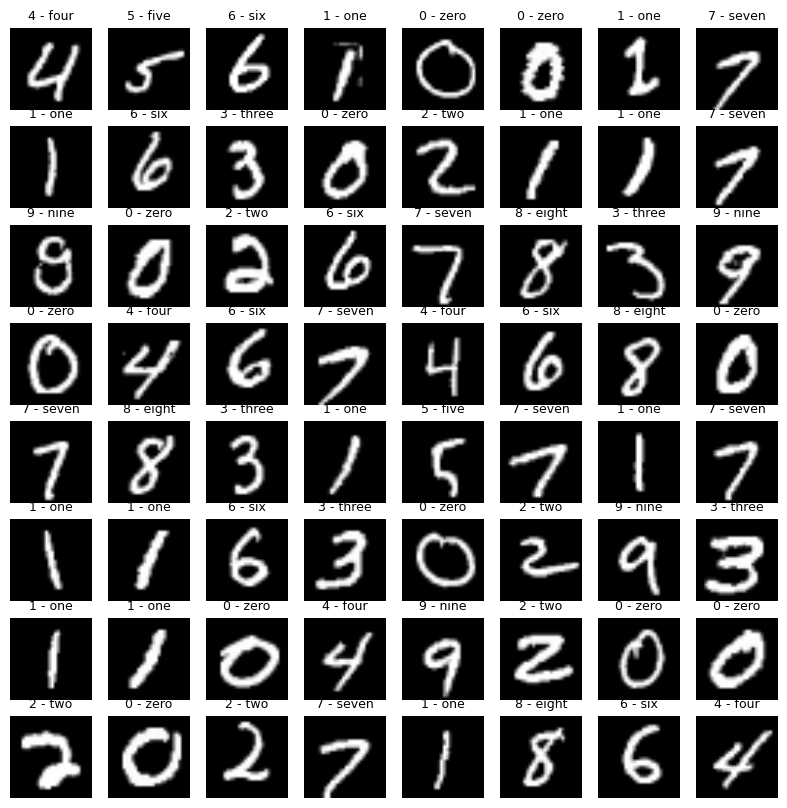

In [24]:
# 获取一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break

# 一个batch里的图片可视化
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
plt.figure(figsize=(10, 10))
for ii in np.arange(len(batch_y)):
    plt.subplot(8, 8, ii+1)
    plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray,interpolation='bilinear')
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.1)
plt.show()
# 测试集数据预处理
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)  # [10000, 1, 28, 28]
test_data_y = test_data.targets  # 测试集的标签 [10000]
test_data_x, test_data_y = test_data_x.to(device), test_data_y.to(device) #使用GPU训练 

In [11]:
### Choosing 
myconvnet = resnet34().to(device)

In [14]:
# 定义网络训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs):
    batch_num = len(traindataloader)                   # 获取训练总batch数
    train_batch_num = round(batch_num * train_rate)    # 按照train_rate比例进行训练集的划分
    
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    elapsed=[]
    since = time.time()
    
    # 训练轮次循环
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
 
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
 
        # 每个epoch有两个训练阶段
        for step, (b_x, b_y) in enumerate(traindataloader):
            b_x, b_y = b_x.to(device), b_y.to(device) #使用GPU训练 
            if step < train_batch_num:         # 训练集
                model.train()                  # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)  # 计算损失函数
                optimizer.zero_grad()          # 清空上一层梯度
                loss.backward()                # 反向传播
                optimizer.step()               # 更新优化器的学习率
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval()                   # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
 
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
 
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
 
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
 
        # 当精度创新高，复制模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        elapsed.append(time_use)
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
 
        # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch": range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all": train_acc_all,
              "val_acc_all": val_acc_all,
              }
    )
    return model, train_process, elapsed

In [15]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # 损失函数
myconvnet, train_process, elapsed= train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)

Epoch 0/24
0 Train Loss: 0.2109 Train Acc: 0.9384
0 Val Loss: 0.1171 Val Acc: 0.9658
Train and val complete in 0m 11s
Epoch 1/24
1 Train Loss: 0.0851 Train Acc: 0.9769
1 Val Loss: 0.0863 Val Acc: 0.9749
Train and val complete in 0m 21s
Epoch 2/24
2 Train Loss: 0.0697 Train Acc: 0.9809
2 Val Loss: 0.0679 Val Acc: 0.9824
Train and val complete in 0m 31s
Epoch 3/24
3 Train Loss: 0.0531 Train Acc: 0.9854
3 Val Loss: 0.0651 Val Acc: 0.9826
Train and val complete in 0m 42s
Epoch 4/24
4 Train Loss: 0.0518 Train Acc: 0.9854
4 Val Loss: 0.0771 Val Acc: 0.9790
Train and val complete in 0m 53s
Epoch 5/24
5 Train Loss: 0.0473 Train Acc: 0.9869
5 Val Loss: 0.0744 Val Acc: 0.9802
Train and val complete in 1m 3s
Epoch 6/24
6 Train Loss: 0.0415 Train Acc: 0.9880
6 Val Loss: 0.0721 Val Acc: 0.9839
Train and val complete in 1m 14s
Epoch 7/24
7 Train Loss: 0.0408 Train Acc: 0.9886
7 Val Loss: 0.0690 Val Acc: 0.9808
Train and val complete in 1m 26s
Epoch 8/24
8 Train Loss: 0.0390 Train Acc: 0.9894
8 Val L

In [16]:
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y.cpu(), pre_lab.cpu())
precision, recall, f1_score, _ = precision_recall_fscore_support(test_data_y.cpu(), pre_lab.cpu(), average='weighted')
print(f'Accuracy: {acc}')
print(f'Precision: {round(precision,4)}')
print(f'Recall: {recall}')
print(f'F1-Score: {round(f1_score,4)}')

Accuracy: 0.9909
Precision: 0.9909
Recall: 0.9909
F1-Score: 0.9909


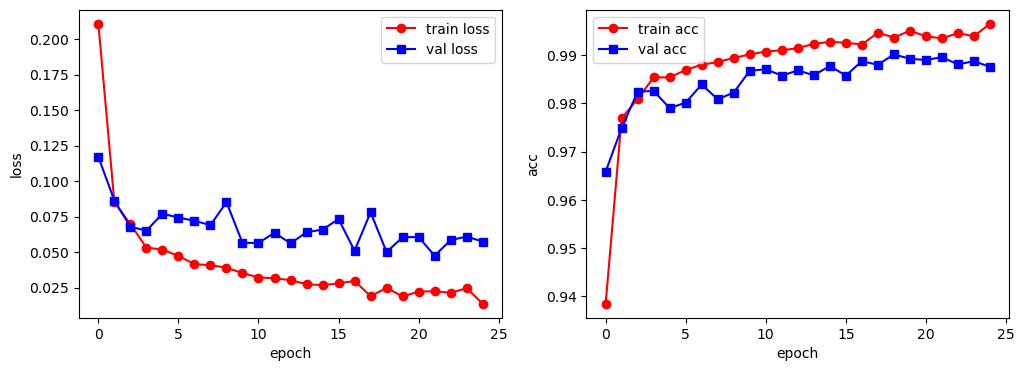

In [17]:
# 训练结果可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
 
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()
 

Text(95.72222222222221, 0.5, 'Predicted label')

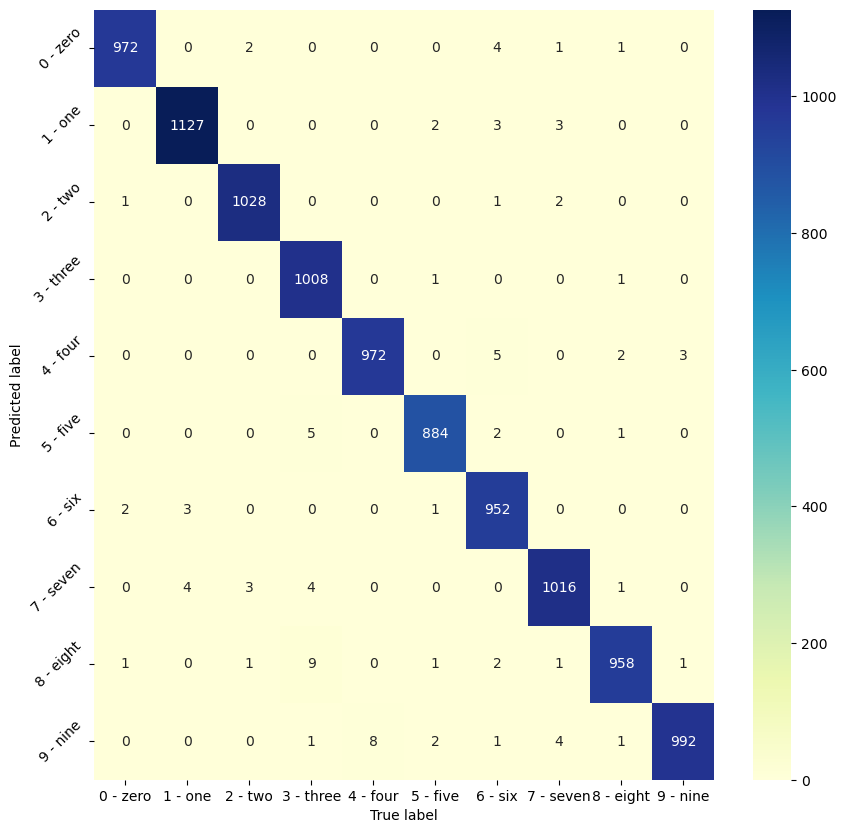

In [18]:
# 计算混淆矩阵可视化
con_mat = confusion_matrix(test_data_y.cpu(), pre_lab.cpu())
con_mat_df = pd.DataFrame(con_mat, index=class_label, columns=class_label)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(con_mat_df, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.set_ticklabels(class_label), rotation=0, ha='right')
heatmap.yaxis.set_ticklabels(heatmap.xaxis.set_ticklabels(class_label), rotation=45, ha='right')
plt.xlabel("True label")
plt.ylabel("Predicted label")

## SVD

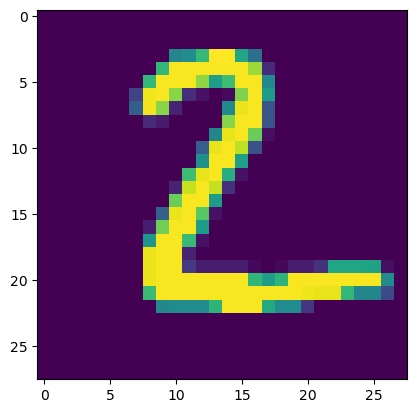

In [44]:
image=test_data_x[1].cpu().squeeze().numpy()
plt.imshow(image, cmap='viridis', interpolation='none')
U, S, Vt = np.linalg.svd(image)

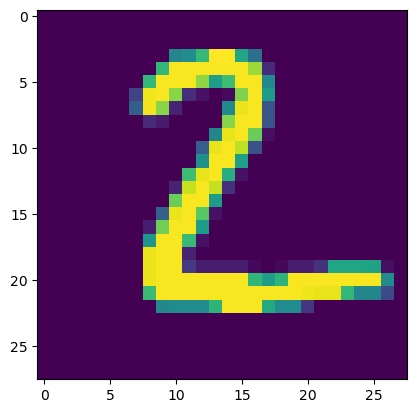

In [45]:
for k in [5,10,15,20,25]:
    compressed_image = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    plt.imshow(compressed_image, cmap='viridis', interpolation='none')

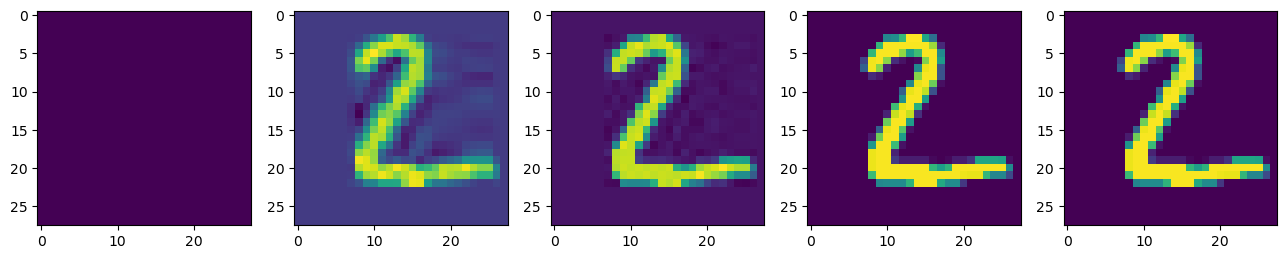

In [47]:
plt.figure(figsize=(16, 12))
i=1
for k in range(0,25,5):
    plt.subplot(1,5,i)
    compressed_image = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    plt.imshow(compressed_image, cmap='viridis', interpolation='none')
    i+=1